<a href="https://colab.research.google.com/github/alejogiley/Novartis-Hackaton-7/blob/master/Notebooks/Lee_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting affinities of antibiotic candidates to a DNA Gyrase

### Anaconda installation

In [0]:
#!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
#!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
#!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local

#!conda install -q -y --prefix /usr/local -c omnia --no-update-deps pdbfixer=1.4
#!conda install -q -y --prefix /usr/local -c conda-forge --no-update-deps xgboost=0.6a2
#!conda install -q -y --prefix /usr/local -c rdkit --no-update-deps rdkit=2017.09.1
#!conda install -q -y --prefix /usr/local -c deepchem --no-update-deps  deepchem-gpu=2.1.0

#import sys
#sys.path.append('/usr/local/lib/python3.6/site-packages/')

#!pip install keras_sequential_ascii

### Dependencies

In [0]:
import os

import numpy  as np      # scientific computing: arrays
import scipy  as sp      # scientific computing: statistics
import pandas as pd      # data analysis tools

# Tensor operations
import tensorflow as tf
import keras.backend as K

# Neural Network
from keras.models import Sequential
from keras.layers import Dropout, BatchNormalization
from keras.layers import Dense, Activation
from keras.optimizers import Adam, SGD
from keras.initializers import RandomUniform
from keras_sequential_ascii import keras2ascii

# Data processing & Cross-validation
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold

# Stats
from scipy.stats import linregress, kendalltau, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(84)

### Functions

In [0]:
def plot_eval(model):
    
    plt.rcParams["figure.figsize"] = (18,6)
    fig, ax = plt.subplots()
    
    c = 'blue'                                   # train -- blue
    ax.scatter(y_train, model.predict(x_train),
               s=65, c=c, zorder=10, edgecolors='k')
    c = 'red'                                    # tests -- red
    ax.scatter(y_test,  model.predict(x_test),
               s=65, c=c, cmap=plt.cm.coolwarm, 
               zorder=10, edgecolors='k')
    
    ax.set_xlabel("pIC50 experimental", fontsize=16)
    ax.set_ylabel("pIC50 prediction",   fontsize=16)
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    # integer limits
    ilims = [int(x+0.5) for x in lims]
    ax.set_xticks(np.arange(*ilims,2))
    ax.set_yticks(np.arange(*ilims,2))
    
    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    plt.show()

In [0]:
def plot_valid(models, titles):
    
    fig, axes = plt.subplots(2, 2, sharey=True)
    
    i = 0
    a = 0
    b = 0
    
    for model in models:
        
        a  = int(i%2)
        b  = int(i/2)
        ax = axes[a, b]
        
        ax.title.set_text(titles[i])
        i += 1
        
        c = vy.astype(int)
        ax.scatter(vy,  model.predict(vx),
                   s=65, c=c, cmap=plt.cm.coolwarm, 
                   zorder=10, edgecolors='k')
        
        ax.set_xlabel("pIC50 experimental", fontsize=16)
        ax.set_ylabel("pIC50 prediction",   fontsize=16)
        
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
        
        # now plot both limits against eachother
        ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        
        # integer limits
        ilims = [int(x+0.5) for x in lims]
        ax.set_xticks(np.arange(*ilims,2))
        ax.set_yticks(np.arange(*ilims,2))
        
        # We change the fontsize of minor ticks label 
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.tick_params(axis='both', which='major', labelsize=14)
        
    plt.show()

In [0]:
def Standarize(x):
    x = (x - x.mean(axis=0)) / x.std(axis=0)
    return x

In [0]:
def Normalize(x):
    #Tanh Estimator
    x = Standarize(x)
    return 0.5 * np.tanh(0.01 * x)

## <font color='green'>Data Processing</font>

### Read IC50 data

In [0]:
# load features dataset
filepath = "https://raw.githubusercontent.com/alejogiley/Novartis-Hackaton-7/master/Data/Gyrase/AZ_Pyrrolamides_features_final.csv"
datasets = pd.read_csv(filepath)

# rename
datasets.rename(columns={'SAU Gyr IC50 (礛)':'pIC50'}, inplace=True)

pattern = "[<]"
filters = datasets.pIC50.str.contains(pattern)
datasets["left_saturated"] = filters

pattern = "[>]"
filters = datasets.pIC50.str.contains(pattern)
datasets["right_saturated"] = filters

# Reorder dataframe
cols = datasets.columns.tolist()
cols = cols[:2] + cols[-2:] + cols[2:-2]
datasets = datasets[cols]

datasets['pIC50'] = datasets['pIC50'].str.replace(r'[><]', '')
datasets['pIC50'] = datasets['pIC50'].apply(lambda x: np.log(float(x)))

# drop Ipc
datasets = datasets.drop(['Ipc'], axis=1)
cols.remove('Ipc')

Check features.

In [8]:
corr = datasets.corr()
corr.loc[(corr['pIC50'] >= 0.4) | (corr['pIC50'] <= -0.4)]['pIC50'][1:]

qed                        0.491180
MolWt                     -0.526664
BertzCT                   -0.503721
PEOE_VSA1                 -0.450455
PEOE_VSA3                 -0.465307
SMR_VSA1                  -0.427446
SlogP_VSA2                -0.509821
TPSA                      -0.533955
EState_VSA2               -0.467875
VSA_EState9               -0.454508
NOCount                   -0.529112
NumAromaticHeterocycles   -0.400436
NumHAcceptors             -0.487935
NumHeteroatoms            -0.593323
NumRotatableBonds         -0.463759
fr_Ar_COO                 -0.486644
f_111                     -0.478565
f_186                     -0.459100
f_456                     -0.492155
f_667                      0.419061
f_807                     -0.456968
f_1242                    -0.411416
f_1403                    -0.471330
f_1601                    -0.400506
f_1634                     0.420678
f_2147                    -0.470485
f_2238                    -0.471330
f_2287                    -0

In [57]:
cols = datasets.columns.tolist()

# Drop empty columns
for col in cols:
    if datasets[col].sum() == 0:
        datasets.drop([col], axis=1, inplace=True)

['Molecule SMILES', 'pIC50', 'left_saturated', 'right_saturated', 'MaxEStateIndex', 'MinEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'MaxPartialCharge', 'MinPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'BalabanJ', 'BertzCT', 'HallKierAlpha', 'Kappa3', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8', 'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_EState10', 'VSA_EState8', 'VSA_EState9', 'FractionCSP3', 'NHOHCount', 'NOCount', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromati

In [0]:
# Create correlation matrix
corr_matrix = datasets.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
for col in to_drop:
    datasets.drop(col, axis=1, inplace=True)

In [75]:
# How many descriptors were removed
old = len(cols[4:])
new = len(datasets.columns.tolist()[4:])
print("%i descriptors were removed" % (old - new))

# Update descriptors list
descriptors = datasets.columns.tolist()[4:]

109 descriptors were removed


### Splitting

Split the machine-learning-ready dataset into __training__, __test__ and __validation__ subsets.

In [0]:
# Input and Output

y = datasets['pIC50'].copy()
y = y.astype('float64').to_numpy()

x = datasets.iloc[:,4:].copy()
x = x.astype('float64').to_numpy()

# S: qualifiers classification

s1 = datasets['left_saturated' ].apply(lambda x: x*1).copy()
s2 = datasets['right_saturated'].apply(lambda x: x*1).copy()

s1 = s1.to_numpy()
s2 = s2.to_numpy()

s0 = s1 + s2

# CUTOFFS: > greater

rcutoff = s2 * datasets['pIC50'].copy().astype('float64')
rcutoff = rcutoff.to_numpy()

# CUTOFFS: < lower

lcutoff = s1 * datasets['pIC50'].copy().astype('float64')
lcutoff = lcutoff.to_numpy()

In [0]:
# split dataset and update \
# qualifiers S and CUTOFFS

f = np.vstack((x.T, lcutoff, rcutoff, s1, s2, s0)).T
f_train, f_test, y_train, y_test = train_test_split(f, y, test_size=0.25, random_state=42)

x_test  = f_test[:,: -5]
x_train = f_train[:,:-5]

s0_train = f_train[:,-1]
s2_train = f_train[:,-2]
s1_train = f_train[:,-3]
rcutoff_train = f_train[:,-4]
lcutoff_train = f_train[:,-5]

# Normalized features
# tanh normalization

x_train = Normalize(x_train)
x_test  = Normalize(x_test) 

In [78]:
datasets.head(2)

,Molecule SMILES,pIC50,left_saturated,right_saturated,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,FpDensityMorgan2,BalabanJ,BertzCT,HallKierAlpha,Kappa3,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,...,f_3662,f_3672,f_3693,f_3707,f_3727,f_3763,f_3770,f_3778,f_3786,f_3793,f_3798,f_3802,f_3806,f_3821,f_3831,f_3838,f_3839,f_3864,f_3873,f_3897,f_3914,f_3921,f_3940,f_3959,f_3963,f_3980,f_3994,f_4003,f_4006,f_4009,f_4015,f_4026,f_4033,f_4034,f_4039,f_4044,f_4048,f_4057,f_4062,f_4095
0,c1cc(c(nc1)N2CCC(CC2)NC(=O)c3cc(c([nH]3)Cl)Cl)...,5.991465,False,True,12.198481,-0.435597,0.013283,0.623001,384.223,0.311075,-0.350740,1.400000,2.120000,1.606288,782.714558,-2.32,3.853433,15.200677,10.847038,0.0,5.817863,5.90718,5.687386,14.908855,4.983979,0.0,0.0,23.201880,24.974377,31.394564,9.945944,9.717848,40.614309,15.284746,0.0,18.883484,17.989423,50.379934,0.0,10.216698,...,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CC(C)c1c(cc([nH]1)C(=O)NC2CCN(CC2)c3c(cccn3)[N...,3.912023,False,True,12.517532,-0.411106,0.011515,0.550709,436.310,0.311075,-0.353241,1.444444,2.148148,1.607439,843.272683,-2.42,4.292290,15.200677,5.693928,0.0,5.817863,5.90718,5.687386,14.908855,4.983979,0.0,0.0,13.847474,46.822227,41.561212,4.923311,9.717848,33.342373,15.284746,0.0,38.648865,17.989423,50.370839,0.0,10.216698,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## <font color='green'>Neural Network</font>

A simple Fully Connected Neural Network

### <font color='blue'>LOSS FUNCTION (with censored data)</font>

In [0]:
def custom_loss(y_true, y_pred):
    # get deltas
    z = y_pred - y_true
    r = y_pred - rcutoff_train
    l = y_pred - lcutoff_train
    # qualifiers adjusted Loss function
    norm = (1-s0_train) * K.square(z)
    righ = s2_train * K.relu(K.sign(r) * K.square(r))
    left = s1_train * K.relu(K.sign(l) * K.square(l))
    # return mean value
    return K.mean( norm + left + righ, axis=-1)

### Fully Connected Net

In [0]:
#The performance of common machine-learning algorithms can be very sensitive 
#to preprocessing of the data, neural networks mostly. Here we will normalize 
#the features and log(IC50) to have zero-mean and unit-standard-deviation 
#BatchNormalization

# Function to create model

def create_model(x):
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(units=100, 
                    input_shape=(x, ), 
                    kernel_initializer='random_uniform',
                    bias_initializer='ones'))
    model.add(Dropout(0.2))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    
    # hidden layer
    model.add(Dense(units=50))
    model.add(Dropout(0.2))
    model.add(Activation("relu"))
    # hidden layer
    model.add(Dense(units=25))
    model.add(Dropout(0.2))
    model.add(Activation("relu"))
    # output layer
    model.add(Dense(units=1, activation='linear'))
    
    model.compile(loss=custom_loss,                     # Custom loss function
                  optimizer=Adam(lr=1e-4, decay=1e-6),  # Adam optimizer
                  metrics=['mse']) 	                    # measure performace
    return model

In [0]:
%%capture

# input dimensions
input_dim = x.shape[1]

# Clearing the NN
network = None 
network = create_model(input_dim) 

In [95]:
# Visulaize
keras2ascii(network)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####         480
               Dense   XXXXX -------------------     48100    87.7%
                       #####         100
             Dropout    | || -------------------         0     0.0%
                relu   #####         100
  BatchNormalization    μ|σ  -------------------       400     0.7%
                       #####         100
               Dense   XXXXX -------------------      5050     9.2%
                       #####          50
             Dropout    | || -------------------         0     0.0%
                relu   #####          50
               Dense   XXXXX -------------------      1275     2.3%
                       #####          25
             Dropout    | || -------------------         0     0.0%
                relu   #####          25
               Dense   XXXXX -------------------        26     0.0%
                       #####           1


### Run Lola, Run

Parameters are not optimized! No Grid search.

In [0]:
%%capture

# Train neural network
history = network.fit(x_train,                          # Features
                      y_train,                          # Target
                      epochs=1600,                      # Number of epochs
                      verbose=0,                        # No output
                      batch_size=20,                    # Number of observations per batch
                      validation_data=(x_test, y_test)) # Data for evaluation

### Save model

In [16]:
network.save("/content/network.h5")
print("Saved model to disk")

Saved model to disk


### <font color='red'>Load model</font>


In [0]:
#network = None
#network = create_model(x.shape[1])
#network.load_weights('/content/network.h5')

### Optimization

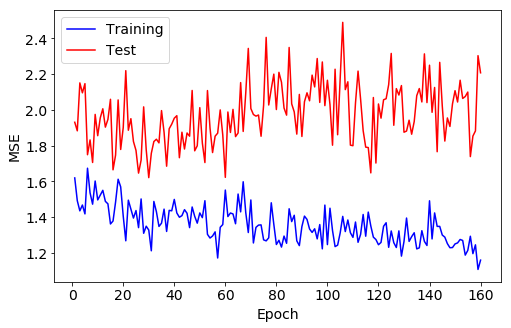

In [105]:
plt.rcParams["figure.figsize"] = (8,5)    # plot size

# Get training and test loss histories
training_loss = history.history['mean_squared_error']
test_loss = history.history['val_mean_squared_error']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'b-')
plt.plot(epoch_count, test_loss, 'r-')
plt.legend(['Training', 'Test'], fontsize=14)
#plt.ylim([0,10])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MSE',   fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Plot prediction vs experiment

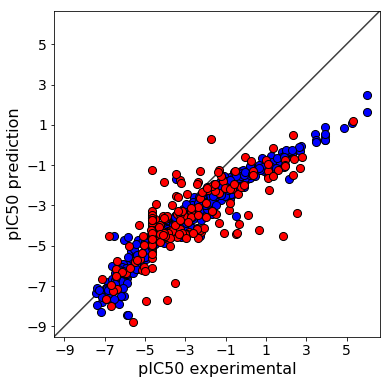

In [106]:
plot_eval(network)

### Statistics

In [20]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, network.predict(x_test)[:,0])
tau, p_value                                = kendalltau(y_test, network.predict(x_test)[:,0])
mae                                         = mean_absolute_error(y_test, network.predict(x_test)[:,0])

print("R2          : %s" % r_value)
print("MAE         : %s" % mae)
print("Kendall Tau : %s" % tau)

R2          : 0.7991247141997119
MAE         : 0.9192380513553223
Kendall Tau : 0.6474262882511193


### Cross-validation

In [21]:
kf = KFold(n_splits=4, random_state=3, shuffle=True)

for train_index, test_index in kf.split(f):
    # split trick
    f_train, f_test = f[train_index], f[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #
    x_train = f_train[:,:-5]
    x_test  = f_test[:,:-5]
    #
    s0_train = f_train[:,-1]
    s2_train = f_train[:,-2]
    s1_train = f_train[:,-3]
    #
    rcutoff_train = f_train[:,-4]
    lcutoff_train = f_train[:,-5]
    #
    x_train = Normalize(x_train)
    x_test  = Normalize(x_test) 
    # finished
    
    network = None
    network = create_model(x_test.shape[1]) 
    network.fit(x_train, y_train, epochs=600, verbose=0, batch_size=50)
    
    slope, intercept, r_value, p_value, std_err = linregress(y_test, network.predict(x_test)[:,0])
    tau, p_value                                = kendalltau(y_test, network.predict(x_test)[:,0])
    mae                                         = mean_absolute_error(y_test, network.predict(x_test)[:,0])
    
    print("#------------------------#")
    print("R2          : %s" % r_value)
    print("MAE         : %s" % mae)
    print("Kendall Tau : %s" % tau)

#------------------------#
R2          : 0.781494403389971
MAE         : 0.9500645495646203
Kendall Tau : 0.6290575652467056
#------------------------#
R2          : 0.7926964498153982
MAE         : 1.0002554947968532
Kendall Tau : 0.6432884930674514
#------------------------#
R2          : 0.7905714599918736
MAE         : 1.1394846118322093
Kendall Tau : 0.6221224627665661
#------------------------#
R2          : 0.8271672279134834
MAE         : 0.9492073748331807
Kendall Tau : 0.6588914328732105


## <font color='green'>Linear Model</font>

A strightforward linear regression model.

### Single Layer Net

In [0]:
# Function to create model
def create_linear(x):
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(units=1, 
                    input_shape=(x, ), 
                    kernel_initializer='random_uniform',
                    bias_initializer='ones'))
    model.add(Activation("linear"))
    
    model.compile(loss=custom_loss,                     # Custom loss function
                  optimizer=Adam(lr=1e-3, decay=1e-6),  # Adam optimizer
                  metrics=['accuracy']) 	            # measure performace
    return model

In [0]:
input_dim = x.shape[1]

# Clearing the LM
shallow = None 
shallow = create_linear(input_dim)                      # model

### Rum, Rum

In [0]:
# Train shallow model
history = shallow.fit(x_train,                          # Features
                      y_train,                          # Target
                      epochs=600,                       # Number of epochs
                      verbose=0,                        # No output
                      validation_data=(x_test, y_test)) # Data for evaluation

### Save model

In [25]:
shallow.save("/content/shallow.h5")
print("Saved model to disk")

Saved model to disk


### <font color='red'>Load model</font>

In [0]:
#shallow = None
#shallow = create_linear(x.shape[1])
#shallow.load_weights('/content/shallow.h5')

### Plot prediction vs experiment

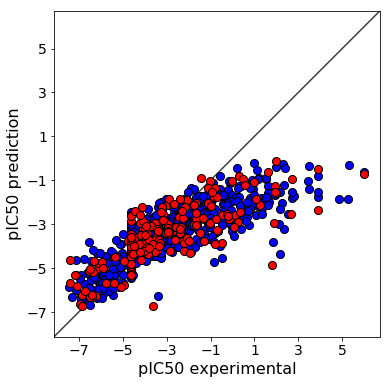

In [27]:
plot_eval(shallow)

### Statistics

In [28]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, shallow.predict(x_test)[:,0])
tau, p_value                                = kendalltau(y_test, shallow.predict(x_test)[:,0])
mae                                         = mean_absolute_error(y_test, shallow.predict(x_test)[:,0])

print("R2          : %s" % r_value)
print("MAE         : %s" % mae)
print("Kendall Tau : %s" % tau)

R2          : 0.7882001992033806
MAE         : 0.9855614576033078
Kendall Tau : 0.6606410118240156


### Cross-validation

In [29]:
kf = KFold(n_splits=4, random_state=3, shuffle=True)

for train_index, test_index in kf.split(f):
    # split trick
    f_train, f_test = f[train_index], f[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #
    x_train = f_train[:,:-5]
    x_test  = f_test[:,:-5]
    #
    s0_train = f_train[:,-1]
    s2_train = f_train[:,-2]
    s1_train = f_train[:,-3]
    #
    rcutoff_train = f_train[:,-4]
    lcutoff_train = f_train[:,-5]
    #
    x_train = Normalize(x_train)
    x_test  = Normalize(x_test) 
    # finished
    
    shallow = None 
    shallow = create_model(x_test.shape[1])
    shallow.fit(x_train, y_train, epochs=600, verbose=0)
    
    slope, intercept, r_value, p_value, std_err = linregress(y_test, shallow.predict(x_test)[:,0])
    tau, p_value                                = kendalltau(y_test, shallow.predict(x_test)[:,0])
    mae                                         = mean_absolute_error(y_test, shallow.predict(x_test)[:,0])
    
    print("#------------------------#")
    print("R2          : %s" % r_value)
    print("MAE         : %s" % mae)
    print("Kendall Tau : %s" % tau)

#------------------------#
R2          : 0.7957818986299591
MAE         : 0.9351960177050195
Kendall Tau : 0.633081979407781
#------------------------#
R2          : 0.7789490855242723
MAE         : 1.005714421373148
Kendall Tau : 0.6528202278656807
#------------------------#
R2          : 0.7919837875531698
MAE         : 1.0743367081388502
Kendall Tau : 0.6433744485314862
#------------------------#
R2          : 0.825227254222541
MAE         : 0.9215529071555802
Kendall Tau : 0.6502135212772171


## <font color='green'>Control FCNN</font>

Repeat the previous methods but ignore censored data

### <font color='blue'>LOSS FUNCTION (without censored data)</font>

In [0]:
def normal_loss(y_true, y_pred):
    # get deltas
    z = y_pred - y_true
    # Loss function
    return K.mean((1-s0_train)*K.square(z), axis=-1)

### Fully Connected Neural Network

In [0]:
#The performance of common machine-learning algorithms can be very sensitive 
#to preprocessing of the data, neural networks mostly. Here we will normalize 
#the features and log(IC50) to have zero-mean and unit-standard-deviation 
#BatchNormalization

# Function to create model

def create_model(x):
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(units=100, 
                    input_shape=(x, ), 
                    kernel_initializer='random_uniform',
                    bias_initializer='ones'))
    model.add(Dropout(0.2))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    # hidden layer
    model.add(Dense(units=50))
    model.add(Dropout(0.2))
    model.add(Activation("relu"))
    # hidden layer
    model.add(Dense(units=25))
    model.add(Dropout(0.2))
    model.add(Activation("relu"))
    # output layer
    model.add(Dense(units=1, activation='linear'))
    
    model.compile(loss=normal_loss,                     # Normal loss function
                  optimizer=Adam(lr=1e-3, decay=1e-6),  # Adam optimizer
                  metrics=['mse']) 	                    # measure performace
    return model

In [0]:
# input dimensions
input_dim = x.shape[1]

# fix random seed
seed = 84
np.random.seed(seed)

# Clearing the NN
network2 = None 
network2 = create_model(input_dim) 

### Corre Lolita

In [0]:
%%capture

# Train neural network
history = network2.fit(x_train,                          # Features
                       y_train,                          # Target
                       epochs=600,                       # Number of epochs
                       verbose=0,                        # No output
                       batch_size=50,                    # Number of observations per batch
                       validation_data=(x_test, y_test)) # Data for evaluation

### Save model

In [34]:
network2.save("/content/network2.h5")
print("Saved model to disk")

Saved model to disk


### <font color='red'>Load model</font>

In [0]:
#network2 = None
#network2 = create_model(x.shape[1])
#network2.load_weights('/content/network2.h5')

### Evaluation

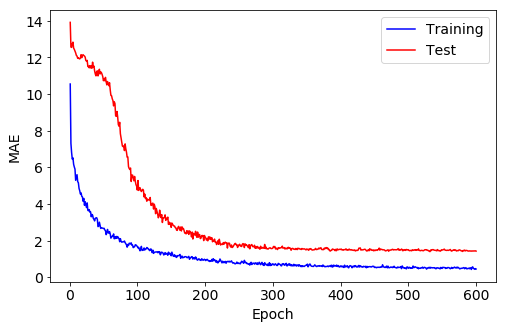

In [36]:
plt.rcParams["figure.figsize"] = (8,5)    # plot size

# Get training and test loss histories
training_loss = history.history['mean_squared_error']
test_loss = history.history['val_mean_squared_error']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'b-')
plt.plot(epoch_count, test_loss, 'r-')
plt.legend(['Training', 'Test'], fontsize=14)
#plt.ylim([0,10])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MAE',  fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Predictions versus Experiments

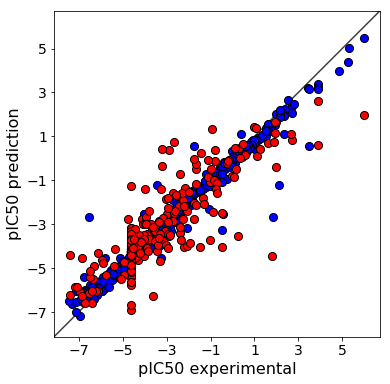

In [37]:
plot_eval(network2)

### Statistics

In [38]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, network2.predict(x_test)[:,0])
tau, p_value                                = kendalltau(y_test, network2.predict(x_test)[:,0])
mae                                         = mean_absolute_error(y_test, network2.predict(x_test)[:,0])

print("R2          : %s" % r_value)
print("MAE         : %s" % mae)
print("Kendall Tau : %s" % tau)

R2          : 0.8473285494070957
MAE         : 0.8276776039259409
Kendall Tau : 0.6782767676481313


### Cross-validation

In [39]:
kf = KFold(n_splits=4, random_state=3, shuffle=True)

for train_index, test_index in kf.split(f):
    # split trick
    f_train, f_test = f[train_index], f[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #
    x_train = f_train[:,:-5]
    x_test  = f_test[:,:-5]
    #
    s0_train = f_train[:,-1]
    s2_train = f_train[:,-2]
    s1_train = f_train[:,-3]
    #
    rcutoff_train = f_train[:,-4]
    lcutoff_train = f_train[:,-5]
    #
    x_train = Normalize(x_train)
    x_test  = Normalize(x_test) 
    # finished
    
    network2 = None
    network2 = create_model(x_test.shape[1]) 
    network2.fit(x_train, y_train, epochs=600, verbose=0, batch_size=50)
    
    slope, intercept, r_value, p_value, std_err = linregress(y_test, network2.predict(x_test)[:,0])
    tau, p_value                                = kendalltau(y_test, network2.predict(x_test)[:,0])
    mae                                         = mean_absolute_error(y_test, network2.predict(x_test)[:,0])
    
    print("#------------------------#")
    print("R2          : %s" % r_value)
    print("MAE         : %s" % mae)
    print("Kendall Tau : %s" % tau)

#------------------------#
R2          : 0.7973016930356801
MAE         : 0.90203039648554
Kendall Tau : 0.6348860271351596
#------------------------#
R2          : 0.7830838380101107
MAE         : 0.9629079598044569
Kendall Tau : 0.6521058956949193
#------------------------#
R2          : 0.8251791805591068
MAE         : 0.986423402276005
Kendall Tau : 0.6577039633632075
#------------------------#
R2          : 0.8261874552707826
MAE         : 0.8657863560645855
Kendall Tau : 0.6610609107722089


## <font color='green'>Control LM</font>

### Single Layer Net



In [0]:
# Function to create model
def create_linear(x):
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(units=1, 
                    input_shape=(x, ), 
                    kernel_initializer='random_uniform',
                    bias_initializer='ones'))
    model.add(Activation("linear"))
    
    model.compile(loss=normal_loss,                     # Custom loss function
                  optimizer=Adam(lr=1e-3, decay=1e-6),  # Adam optimizer
                  metrics=['accuracy']) 	            # measure performace
    return model

In [0]:
# Clearing the LM
shallow2 = None 
shallow2 = create_linear(input_dim)                      # model

### Jogging

In [0]:
# Train shallow model
history = shallow2.fit(x_train,                          # Features
                       y_train,                          # Target
                       epochs=600,                       # Number of epochs
                       verbose=0,                        # No output
                       validation_data=(x_test, y_test)) # Data for evaluation

### Save model

In [43]:
shallow2.save("/content/shallow2.h5")
print("Saved model to disk")

Saved model to disk


### <font color='red'>Load model</font>

In [0]:
#shallow2 = None
#shallow2 = create_linear(x.shape[1])
#shallow2.load_weights('/content/shallow2.h5')

### Predictions versus Experiments

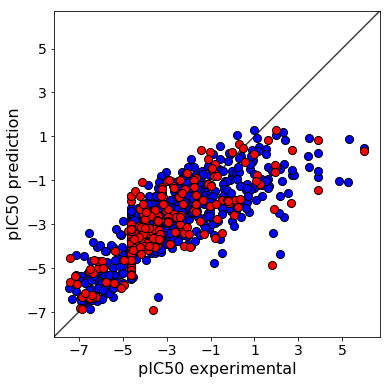

In [45]:
plot_eval(shallow2)

### Statistics

In [46]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, shallow2.predict(x_test)[:,0])
tau, p_value                                = kendalltau(y_test, shallow2.predict(x_test)[:,0])
mae                                         = mean_absolute_error(y_test, shallow2.predict(x_test)[:,0])

print("R2          : %s" % r_value)
print("MAE         : %s" % mae)
print("Kendall Tau : %s" % tau)

R2          : 0.7828928901685309
MAE         : 0.9882998837345203
Kendall Tau : 0.655672207603729


### Cross-validation

In [47]:
kf = KFold(n_splits=4, random_state=3, shuffle=True)

for train_index, test_index in kf.split(f):
    # split trick
    f_train, f_test = f[train_index], f[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #
    x_train = f_train[:,:-5]
    x_test  = f_test[:,:-5]
    #
    s0_train = f_train[:,-1]
    s2_train = f_train[:,-2]
    s1_train = f_train[:,-3]
    #
    rcutoff_train = f_train[:,-4]
    lcutoff_train = f_train[:,-5]
    #
    x_train = Normalize(x_train)
    x_test  = Normalize(x_test) 
    # finished
    
    shallow2 = None 
    shallow2 = create_model(x_test.shape[1])
    shallow2.fit(x_train, y_train, epochs=600, verbose=0)
    
    slope, intercept, r_value, p_value, std_err = linregress(y_test, shallow2.predict(x_test)[:,0])
    tau, p_value                                = kendalltau(y_test, shallow2.predict(x_test)[:,0])
    mae                                         = mean_absolute_error(y_test, shallow2.predict(x_test)[:,0])
    
    print("#------------------------#")
    print("R2          : %s" % r_value)
    print("MAE         : %s" % mae)
    print("Kendall Tau : %s" % tau)

#------------------------#
R2          : 0.8075120219835614
MAE         : 0.8853958886654196
Kendall Tau : 0.6501510463668246
#------------------------#
R2          : 0.7699320309199789
MAE         : 1.0096288598745298
Kendall Tau : 0.6501264767270506
#------------------------#
R2          : 0.7862243149903453
MAE         : 1.00794102270581
Kendall Tau : 0.6302909784677406
#------------------------#
R2          : 0.8362918765053285
MAE         : 0.842102282773626
Kendall Tau : 0.6726081318475227


## <font color='green'>Validation</font>

External dataset from BindingDB for DNA Gyrase

### Data Processing

In [0]:
# load features dataset
filepath = "https://raw.githubusercontent.com/alejogiley/Novartis-Hackaton-7/master/Data/Gyrase/BindingDB_Gyrase_B_features.tsv"
validset = pd.read_csv(filepath)

# Rename columns
validset.rename(columns={'IC50':'pIC50'}, inplace=True)
validset.rename(columns={'Ligand SMILES':'Molecule SMILES'}, inplace=True)

# Modify dataset
validset['pIC50'] = validset['pIC50'].apply(lambda x: np.log(float(x)))
validset = validset.drop(['Ipc'], axis=1)

# New columns
pattern = "[<]"
filters = validset.Censorship.str.contains(pattern)
validset["left_saturated"] = filters

pattern = "[>]"
filters = validset.Censorship.str.contains(pattern)
validset["right_saturated"] = filters

# Reorder dataframe
# cols = validset.columns.tolist()
# cols = cols[:1] + cols[-4:] + cols[1:-4]
# validset = validset[cols]

# Reorder dataframe
# validset = validset[list(datasets.columns)]

# Remove SMILES
# validset = validset[~validset['Molecule SMILES'].isin(datasets['Molecule SMILES'].values)]

In [0]:
# input and output
vy = validset['pIC50'].copy()
vy = vy.astype('float64').to_numpy()

vx = validset[descriptors].copy()
vx = vx.astype('float64').to_numpy()

# Normalized features
vx = Normalize(vx)

### Plot pIC50 predictions

ValueError: ignored

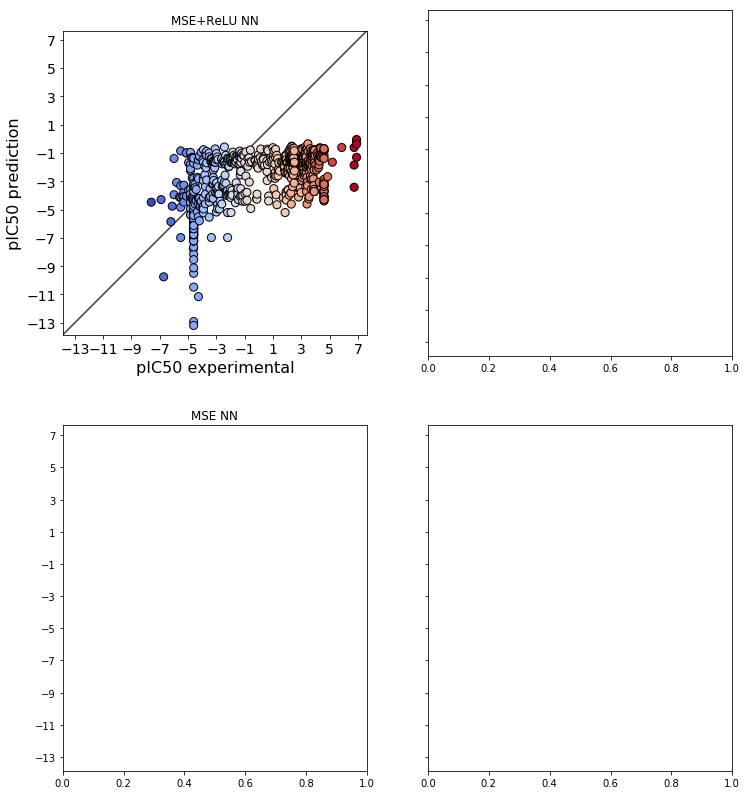

In [113]:
models = [network, network2, shallow, shallow2]
titles = ['MSE+ReLU NN','MSE NN','MSE+ReLU LM','MSE LM']

plt.rcParams["figure.figsize"] = (12,14)
plot_valid(models, titles)

### Statistical Performance

In [51]:
labels = ['MSE+ReLu NN', 'MSE NN', 'MSE+ReLu LM', 'MSE LM']

i = 0
for name in [network, network2, shallow, shallow2]:
    
    slope, intercept, r_value, p_value, std_err = linregress(vy, name.predict(vx)[:,0])
    tau, p_value                                = kendalltau(vy, name.predict(vx)[:,0])
    rho, p_value                                = spearmanr( vy, name.predict(vx)[:,0])
    mae                                         = mean_absolute_error(vy, name.predict(vx)[:,0])
    mse                                         = mean_squared_error( vy, name.predict(vx)[:,0])
    
    print("##### METHOD: %s" % labels[i])
    print("Kendall Tau : %s" % tau)
    print("R2          : %s" % r_value)
    print("Spearman    : %s" % rho)
    print("MAE         : %s" % mae)
    print("RMSE        : %s" % np.sqrt(mse))
    print("")
    
    i+=1

##### METHOD: MSE+ReLu NN
Kendall Tau : 0.30700289700251654
R2          : 0.520422265462184
Spearman    : 0.45550986245950037
MAE         : 3.713035677774367
RMSE        : 4.335744992222716

##### METHOD: MSE NN
Kendall Tau : 0.29489415221279863
R2          : 0.5141213575537018
Spearman    : 0.4380679400110008
MAE         : 3.317144966413835
RMSE        : 3.884198260642191

##### METHOD: MSE+ReLu LM
Kendall Tau : 0.2585124579438446
R2          : 0.4796318410834793
Spearman    : 0.3873313438487491
MAE         : 3.6102601287549896
RMSE        : 4.182256363863

##### METHOD: MSE LM
Kendall Tau : 0.2535950134948904
R2          : 0.49074750718887294
Spearman    : 0.3878932783051389
MAE         : 3.152364325405953
RMSE        : 3.646338587739837

